# Import libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import os
from pyfuncs import *

startdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/analysis/'
%qtconsole
# TODO: Get a relphase column working

# Read in selected data, combine into one large dataframe

In [2]:
runDates = ['20210803_1','20210816','20210817_1','20210818_1']

os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)

# Channel names to process
channelsEMG = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
channelsFT = ['fx', 'fy', 'fz', 'mx', 'my', 'mz']

In [27]:


%matplotlib auto
fig, ax = plt.subplots(len(runDates), 3, sharex=True)
for i,d in enumerate(runDates):
    dt = ddf.loc[(ddf.date==d) & (ddf.pulse==1),].copy()
    # for j in np.unique(dt['wb']):
    #     if j % 2 == 0:
    #         wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
    #         ax[i].axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
    for j,m in enumerate(channelsFT[3:]):
        for jj in np.unique(dt['wb']):
            ax[i,j].plot(dt.loc[dt['wb']==jj, 'phase'], dt.loc[dt['wb']==jj, m], alpha=0.6)


Using matplotlib backend: MacOSX


# Look for ways to split by upstroke and downstroke

Why not split upstroke and downstroke (or, at least, split the wingstroke into halves) by taking the other points where the hilbert transform angle flips across zero?

In [23]:

dt = df.loc[(df.date=='20210817_1') & (df.pulse==1),]

%matplotlib auto
plt.plot(dt.Time, dt.mx)
plt.plot(dt.Time, np.angle(hilbert(dt.fz))/5)
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
# plt.xlim((-18.6,-18.4))

Using matplotlib backend: MacOSX


# Estimating "actual pitch" from pitch torque

I am slightly suspicious of this, partially because I don't trust that we've actually transformed FT matrix to be at the real COM, especially going from individual to individual. How much would that throw off this analysis? Do we have stronger ways to verify?

Right now values don't really make sense; Way too large. Need to verify that torques are properly in Nmm. Also worth noting; bias offsets are applied *after* transformation matrix, and taken from an empty stand. There **will** be torque DC offsets with quiescent moth; need to pull those out, account for in bias?

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


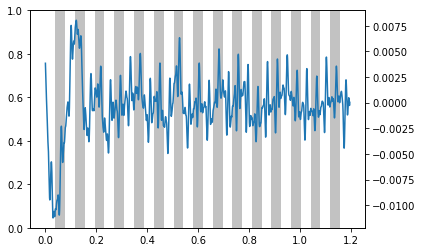

In [89]:
dt = df.loc[(df.date=='20210817_1') & (df.pulse==1),]
dt.Time -= dt.Time.iloc[0]

fsamp = 10000
Iyy = 266.7/1000/(1000**2) # gmm^2 to kg m^2

plt.figure()
time = dt.Time.to_numpy()
mx = dt.mx
theta = cumtrapz(cumtrapz(mx/1000**2/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
plt.plot(time, dt.mx)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time[1:-1], butterfilt(theta, 5, fsamp, order=5, bandtype='high'))

Version of readMatFile that returns only raw voltages